# Support Vector Regression Modelling

## The `housing` problem

We want to predict average house values in suburbs of Boston.

Accesible en https://archive.ics.uci.edu/ml/datasets/Housing

### Attribute Information:

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate per \$10,000 
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: % lower status of the population 
14. MEDV: Median value of owner-occupied homes in \$1000's

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, time
import sklearn as skl
import seaborn as sns

import gzip
import pickle

from sklearn.datasets import load_boston

### Data Loading

In [3]:
#f = r'D:\GoogleDrive\Cursos\datasets\housing.csv'

boston_data = load_boston()

df_housing = pd.DataFrame(data=boston_data['data'], columns=boston_data['feature_names'])
df_housing['MEDV'] = boston_data['target']

print ("n_rows: %d\tn_columns: %d\n" % (df_housing.shape[0], df_housing.shape[1]) )
print ("columns:\t", list(df_housing.columns))

n_rows: 506	n_columns: 14

columns:	 ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [4]:
vars_housing   = list(df_housing.columns[ : -1])
target_housing = df_housing.columns[-1]

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

In [5]:
df_housing.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


#### Boxplots

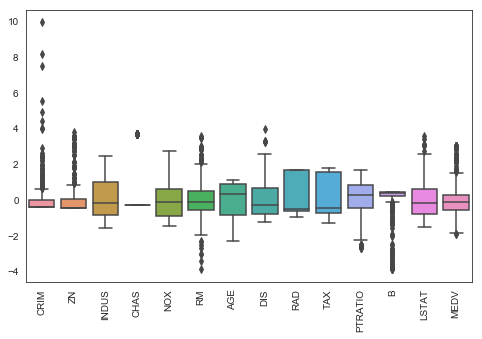

In [6]:
#normalizamos para tener rangos uniformes en histogramas
df_housing_normalizado = (df_housing - df_housing.mean()) / df_housing.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.show()

### Histograms and scatterplots

Plot histograms of groups of 5 variables plus target.

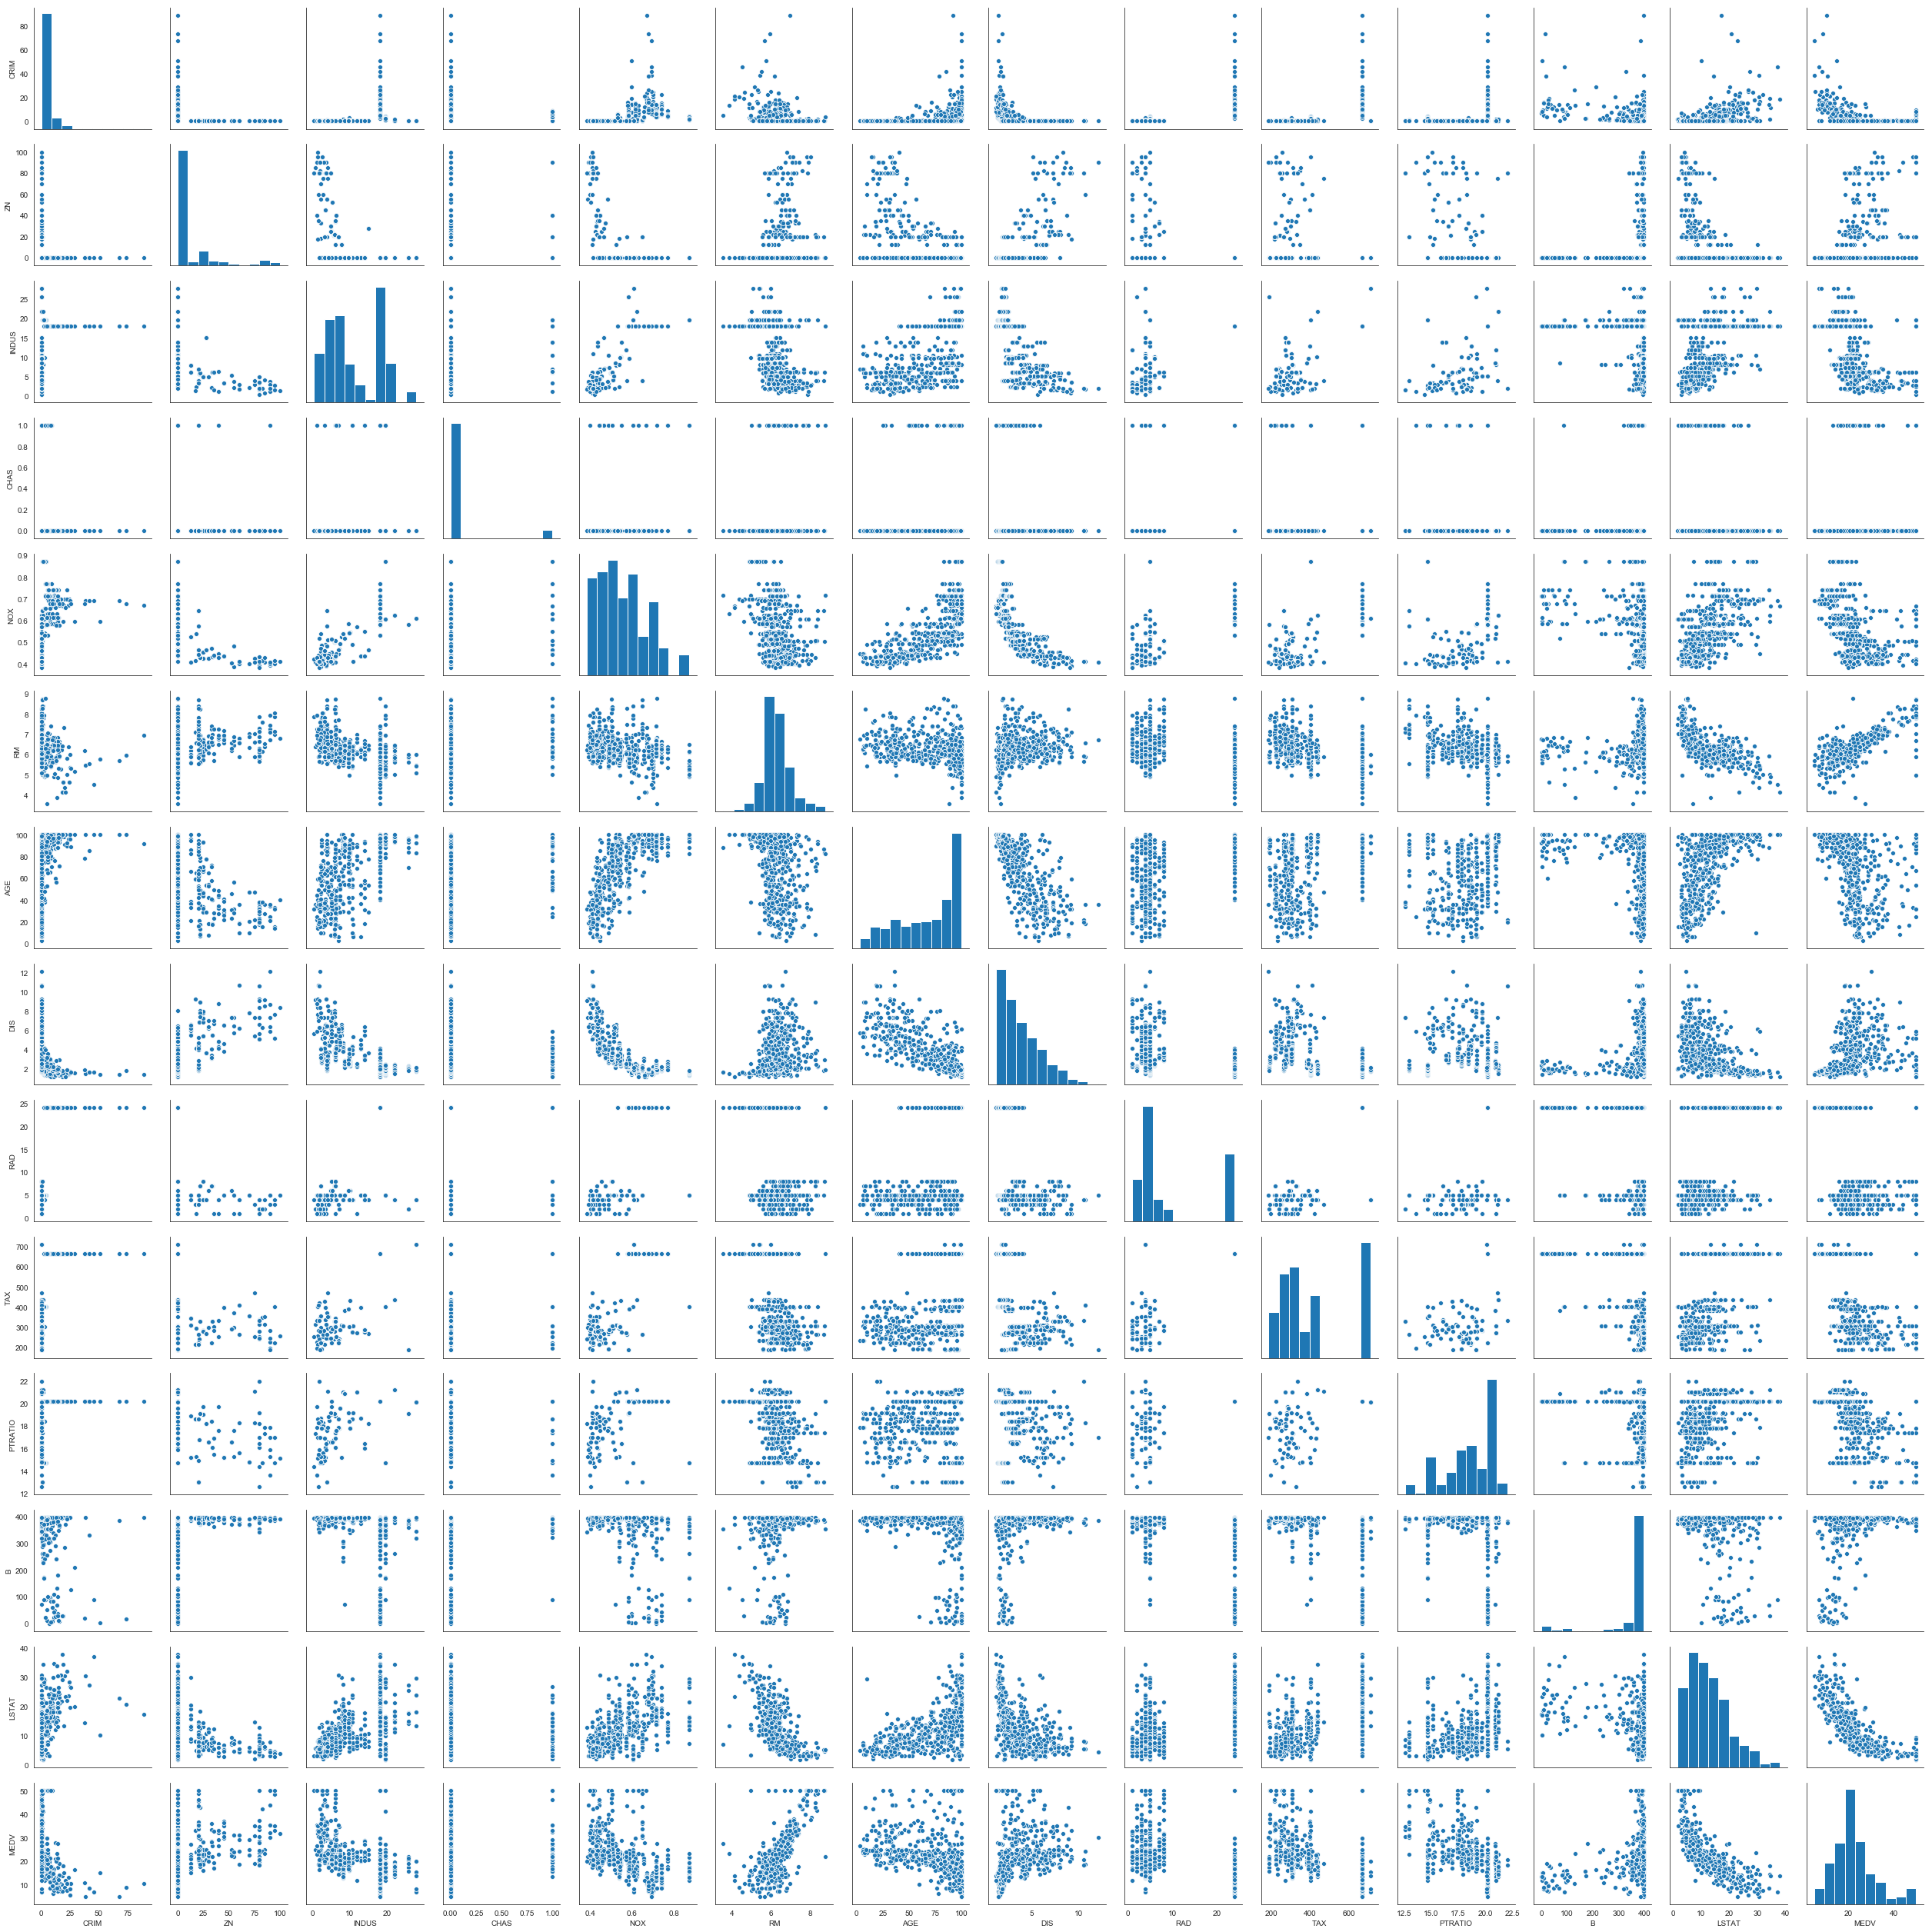

In [7]:
#pair_plot = sns.pairplot( df_housing[ list(vars_housing[ : 5]) + [target_housing] ] )
pair_plot = sns.pairplot( df_housing[vars_housing + [target_housing]] )
plt.show()

We see a clsuter of house values at the right hand side.

They correspond to clipped house values and we remove them.

In [8]:
idx_high_medv = df_housing['MEDV'] < 50.

print("houses below 50K $:", idx_high_medv.sum())

houses below 50K $: 490


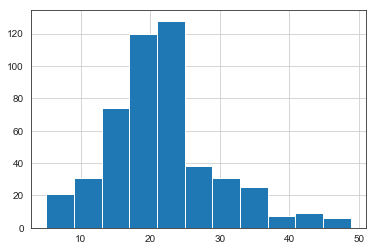

In [9]:
df_housing = df_housing.loc[ idx_high_medv ]

df_housing[target_housing].hist(bins=11)

### Correlations

In [10]:
df_housing.corr().round(decimals=3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000,-0.199,0.408,-0.064,0.420,-0.219,0.354,-0.382,0.627,0.584,0.287,-0.384,0.462,-0.450
ZN,-0.199,1.000,-0.527,-0.054,-0.512,0.311,-0.563,0.673,-0.308,-0.303,-0.382,0.176,-0.422,0.405
INDUS,0.408,-0.527,1.000,0.036,0.765,-0.412,0.638,-0.710,0.596,0.718,0.388,-0.363,0.637,-0.600
CHAS,-0.064,-0.054,0.036,1.000,0.086,0.045,0.071,-0.078,-0.033,-0.068,-0.117,0.042,-0.006,0.075
NOX,0.420,-0.512,0.765,0.086,1.000,-0.323,0.728,-0.768,0.612,0.667,0.188,-0.383,0.612,-0.524
RM,-0.219,0.311,-0.412,0.045,-0.323,1.000,-0.268,0.246,-0.196,-0.282,-0.293,0.119,-0.610,0.687
AGE,0.354,-0.563,0.638,0.071,0.728,-0.268,1.000,-0.743,0.452,0.500,0.268,-0.279,0.638,-0.493
DIS,-0.382,0.673,-0.710,-0.078,-0.768,0.246,-0.743,1.000,-0.492,-0.532,-0.247,0.299,-0.536,0.369
RAD,0.627,-0.308,0.596,-0.033,0.612,-0.196,0.452,-0.492,1.000,0.909,0.456,-0.452,0.510,-0.476
TAX,0.584,-0.303,0.718,-0.068,0.667,-0.282,0.500,-0.532,0.909,1.000,0.452,-0.448,0.566,-0.572


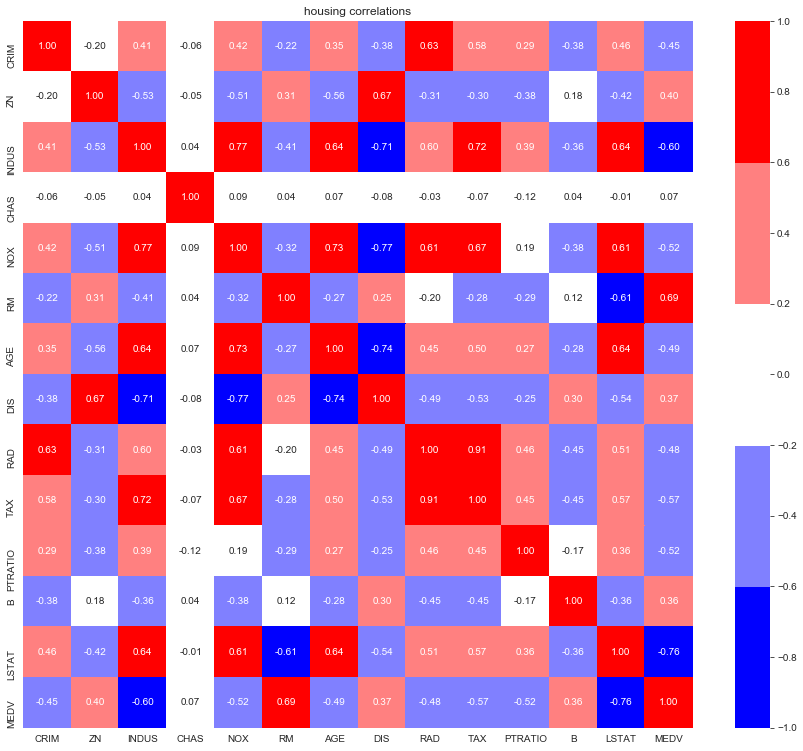

In [11]:
# correlation heatmap
cMap = plt.cm.get_cmap("bwr",lut=5) 

plt.figure( figsize=(15, 13))
plt.title('housing correlations')
h_map = sns.heatmap(df_housing.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=list(df_housing.columns),
                    yticklabels=list(df_housing.columns))

cbar = h_map.collections[0].colorbar
l_ticks = [-1 + k/10. for k in range(0, 21, 2)]
cbar.set_ticks(l_ticks)

## Support Vector Regression

Just getting started ...
Build a first Gaussian kernel model (to be hyperparameterized later).

In [12]:
x = df_housing[vars_housing].values
y = df_housing[target_housing]

MAE: 3.775


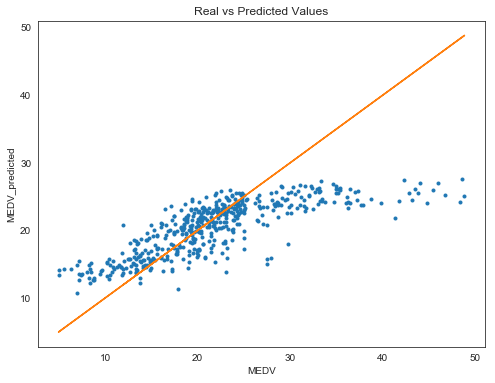

In [13]:
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

#SVR hyperparams
C = 1.
dim = x.shape[1]
gamma = 1./dim
epsilon = y.std()/10.

mm_sc = MinMaxScaler()
svr =  SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

svr_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                ('svr', svr)])

#ajuste sobre la muestra completa, sin split train-test
svr_estimator.fit(x, y)
y_pred = svr_estimator.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

Our first SVR model clearly underfits.

Can we make it to overfit?

Certainy: just

* Use a large $C$ to strongly penalize slacks
* Use a large $\gamma$ to get sharp Gaussians 
* Use a small $\epsilon$  so that any slack/error penalizes

MAE: 0.974


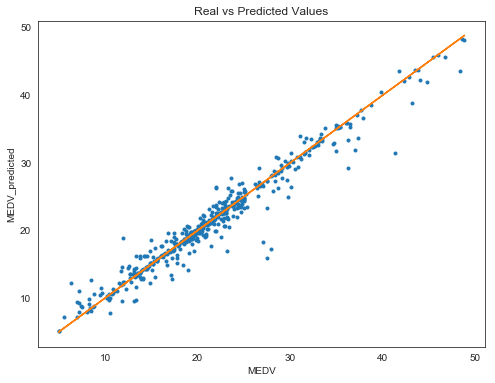

In [14]:
C = 100.
gamma = 16./dim
epsilon = y.std()/50.

svr =  SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)

svr_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                ('svr', svr)])

#ajuste sobre la muestra completa, sin split train-test
svr_estimator.fit(x, y)

y_pred = svr_estimator.predict(x)

print("MAE: %.3f" % mean_absolute_error(y, y_pred))

plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_predicted')
_ = plt.plot(y, y_pred, '.', y, y, '-')

### Finding the optimal `C, gamma, epsilon` by CV

In [15]:
from sklearn.model_selection import GridSearchCV, KFold

# SVR hyperpars
svr = SVR(kernel='rbf', shrinking=True, tol=1.e-3, cache_size= 1000)

svr_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                ('svr', svr)])
        
l_C       = [10.**k for k in range(0, 6)] 
l_gamma   = list( np.array([4.**k for k in range(-1, 5)]) / dim )

l_epsilon = list( y.std() * np.array([2.**k for k in range(-5, 0)]) )

param_grid = {'svr__C': l_C, 'svr__gamma':l_gamma, 'svr__epsilon':l_epsilon}

n_jobs = 2

n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=1)

scoring="neg_mean_absolute_error"

t_0 = time.time()
C_gamma_epsilon_search = GridSearchCV(svr_estimator, 
                                      param_grid=param_grid, 
                                      cv=kf, 
                                      scoring=scoring, 
                                      n_jobs=n_jobs, 
                                      return_train_score=True,
                                      verbose=True)

C_gamma_epsilon_search.fit(x, y)
print("GrdidSearchCV_time: %.f" % (time.time() - t_0))

f_pkl = open("svr_C_gamma_epsilon_cv_search_results_housing.pkl", 'wb') 
pickle.dump(C_gamma_epsilon_search, f_pkl)
f_pkl.close()

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 125 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 729 tasks      | elapsed:   46.0s


GrdidSearchCV_time: 282


[Parallel(n_jobs=2)]: Done 900 out of 900 | elapsed:  4.7min finished


Recover grid search from pickle file, get best parameter values and check they are OK

In [16]:
f_pkl = open('svr_C_gamma_epsilon_cv_search_results_housing.pkl', mode='rb')
C_gamma_epsilon_search = pickle.load(f_pkl)
f_pkl.close()

In [17]:
best_C       = C_gamma_epsilon_search.best_params_['svr__C']
best_gamma   = C_gamma_epsilon_search.best_params_['svr__gamma']
best_epsilon = C_gamma_epsilon_search.best_params_['svr__epsilon']

print("C\tmin %f" % np.min(l_C), "\tbest %f" % best_C, "\tmax %f" % np.max(l_C))
print("gamma\tmin %.3f" % np.min(l_gamma), "\tbest %.3f" % best_gamma, "\tmax %.3f" % np.max(l_gamma))
print("epsilon\tmin %.3f" % np.min(l_epsilon), "\tbest %.3f" % best_epsilon, "\tmax %.3f" % np.max(l_epsilon))

C	min 1.000000 	best 100.000000 	max 100000.000000
gamma	min 0.019 	best 1.231 	max 19.692
epsilon	min 0.246 	best 0.983 	max 3.933


### Performance by hyperpars

Sort by best CV test score

In [18]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(C_gamma_epsilon_search.cv_results_)

df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_svr__C', 'param_svr__gamma', \
                                                                              'param_svr__epsilon', 'mean_test_score']][ : 10]

,param_svr__C,param_svr__gamma,param_svr__epsilon,mean_test_score
75,100,1.23077,0.983163,-1.798508
69,100,1.23077,0.491581,-1.803251
63,100,1.23077,0.245791,-1.834098
104,1000,0.307692,0.983163,-1.847957
81,100,1.23077,1.96633,-1.848555
110,1000,0.307692,1.96633,-1.848905
98,1000,0.307692,0.491581,-1.859689
127,10000,0.0769231,0.491581,-1.873976
92,1000,0.307692,0.245791,-1.879645
133,10000,0.0769231,0.983163,-1.880371


### C vs $\gamma$ plot

We plot a heatmap of $C$ vs $\gamma$ over the optimal $\epsilon$.

normalized_best_params: 100.0 1.2307692307692308 0.125


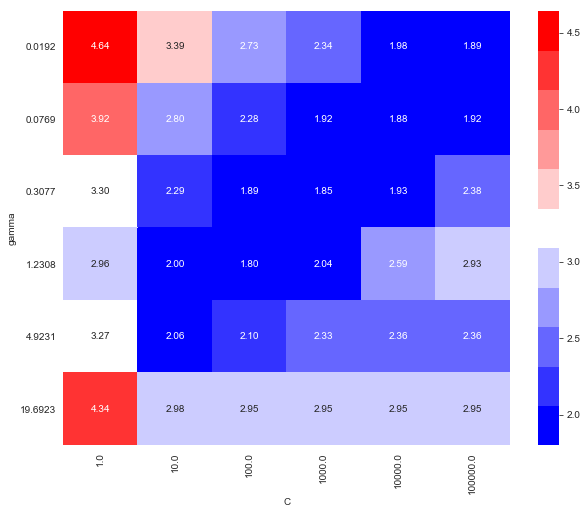

In [19]:
idx_best_eps = df_C_gamma_epsilon_search['param_svr__epsilon'] == best_epsilon

m_t_s = -df_C_gamma_epsilon_search.loc[idx_best_eps].sort_values(by=['param_svr__gamma', 'param_svr__C'])['mean_test_score'].values.reshape(len(l_gamma), -1)

print("normalized_best_params:", best_C, best_gamma, best_epsilon/y.std())

nticks_C = len(l_C)
nticks_gamma = len(l_gamma)

plt.figure( figsize=(10, 8) )

plt.xlabel('C')
plt.ylabel('gamma')

plt.xticks(range(nticks_C), l_C, rotation='vertical')
plt.yticks(range(nticks_gamma), np.array(l_gamma)*dim) 

cMap = plt.cm.get_cmap("bwr",lut=11) 

h_map = sns.heatmap(m_t_s, 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=l_C,
                    yticklabels=np.round(l_gamma, decimals=4))

plt.xlabel('C')
plt.ylabel('gamma')
plt.xticks(rotation='vertical')
plt.yticks(rotation=0)

#cbar = h_map.collections[0].colorbar
#l_ticks = [100.*(0.6 + k/100.) for k in range(0, 21, 2)]
#cbar.set_ticks(l_ticks)

plt.show()

### A MLPRegressor Counterpart

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

hidden_layer_sizes = (20, 20)

mlpr =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     max_iter=10000)

mlpr_estimator = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpr', mlpr)])

        
l_alpha       = [10.**k for k in range(-5, 4)] 

param_grid = {'mlpr__alpha': l_alpha}

n_jobs = 2

#n_folds = 5
#kf = KFold(n_folds, shuffle=True)

scoring="neg_mean_absolute_error"

t_0 = time.time()
alpha_search = GridSearchCV(mlpr_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring=scoring, 
                            n_jobs=n_jobs, 
                            return_train_score=True,
                            verbose=True)

alpha_search.fit(x, y)
print("GrdidSearchCV_time: %.f" % (time.time() - t_0))

f_pkl = open("mlpr_alpha_cv_search_results_housing.pkl", 'wb') 
pickle.dump(alpha_search, f_pkl)
f_pkl.close()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  3.6min finished


GrdidSearchCV_time: 215


In [21]:
f_pkl = open('mlpr_alpha_cv_search_results_housing.pkl', mode='rb')
alpha_search = pickle.load(f_pkl)
f_pkl.close()

In [22]:
best_alpha = alpha_search.best_params_['mlpr__alpha']

print("alphan\tmin %.6f" % np.min(l_alpha), "\tbest %.3f" % best_alpha, "\tmax %.3f" % np.max(l_alpha))

alphan	min 0.000010 	best 100.000 	max 1000.000


## Model Testing

Testing the Best Pipeline SVR and MLP Models

### Comparing MAE and R2

In [23]:
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, cross_validate

#n_folds = 5
#kf = KFold(n_folds, shuffle=True, random_state=1)

n_splits  = 30
test_size = 0.25

random_state = 15908120
ssf = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

best_svr_model  = C_gamma_epsilon_search.best_estimator_
best_mlpr_model = alpha_search.best_estimator_

scores_svr  = cross_val_score(best_svr_model, x, y, scoring="neg_mean_absolute_error", cv=ssf, n_jobs=n_jobs)
scores_mlpr = cross_val_score(best_mlpr_model, x, y, scoring="neg_mean_absolute_error", cv=ssf, n_jobs=n_jobs)

print("svr_MAE:  %.3f" % (-scores_svr.mean()))
print("mlpr_MAE: %.3f" % (-scores_mlpr.mean()))

svr_MAE:  1.866
mlpr_MAE: 2.158


In [24]:
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit, cross_validate

scoring = ['neg_mean_absolute_error', 'r2']
best_svr_model  = C_gamma_epsilon_search.best_estimator_
best_mlpr_model = alpha_search.best_estimator_

scores_svr  = cross_validate(best_svr_model, x, y, scoring=scoring, cv=ssf, n_jobs=n_jobs)
scores_mlpr = cross_validate(best_mlpr_model, x, y, scoring=scoring, cv=ssf, n_jobs=n_jobs)

print("svr_MAE:  %.3f" % (-scores_svr['test_neg_mean_absolute_error'].mean()))
print("mlpr_MAE: %.3f" % (-scores_mlpr['test_neg_mean_absolute_error'].mean()))

print("\nsvr_r2:  %.3f" % (scores_svr['test_r2'].mean()))
print("mlpr_r2: %.3f" % (scores_mlpr['test_r2'].mean()))

svr_MAE:  1.866
mlpr_MAE: 2.150

svr_r2:  0.887
mlpr_r2: 0.840


In [25]:
y_pred_svr  = cross_val_predict(best_svr_model, x, y, cv=kf, n_jobs=n_jobs)
y_pred_mlpr = cross_val_predict(best_mlpr_model, x, y, cv=kf, n_jobs=n_jobs)

print("svr_MAE: %.3f" % mean_absolute_error(y, y_pred_svr))
print("mlpr_MAE: %.3f" % mean_absolute_error(y, y_pred_mlpr))

svr_MAE: 1.799
mlpr_MAE: 2.032


### Comparing Model Fit and Residual Structure

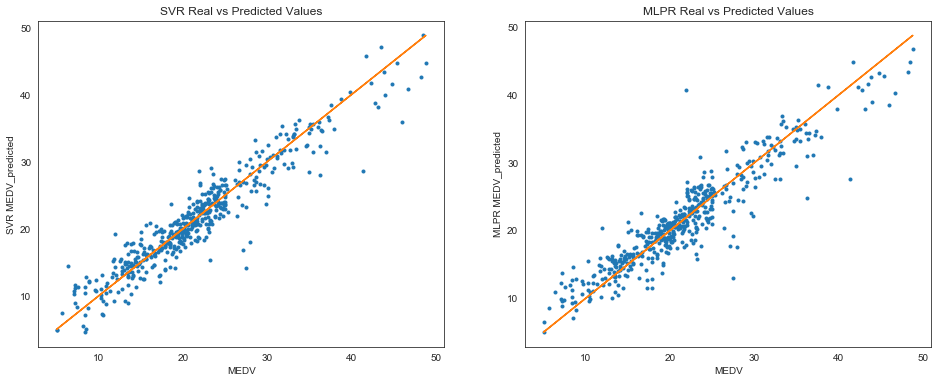

In [26]:
plt.figure( figsize=(16 ,6))

plt.subplot(1, 2, 1)
plt.title('SVR Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('SVR MEDV_predicted')
_ = plt.plot(y, y_pred_svr, '.', y, y, '-')

plt.subplot(1, 2, 2)
plt.title('MLPR Real vs Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MLPR MEDV_predicted')
_ = plt.plot(y, y_pred_mlpr, '.', y, y, '-')

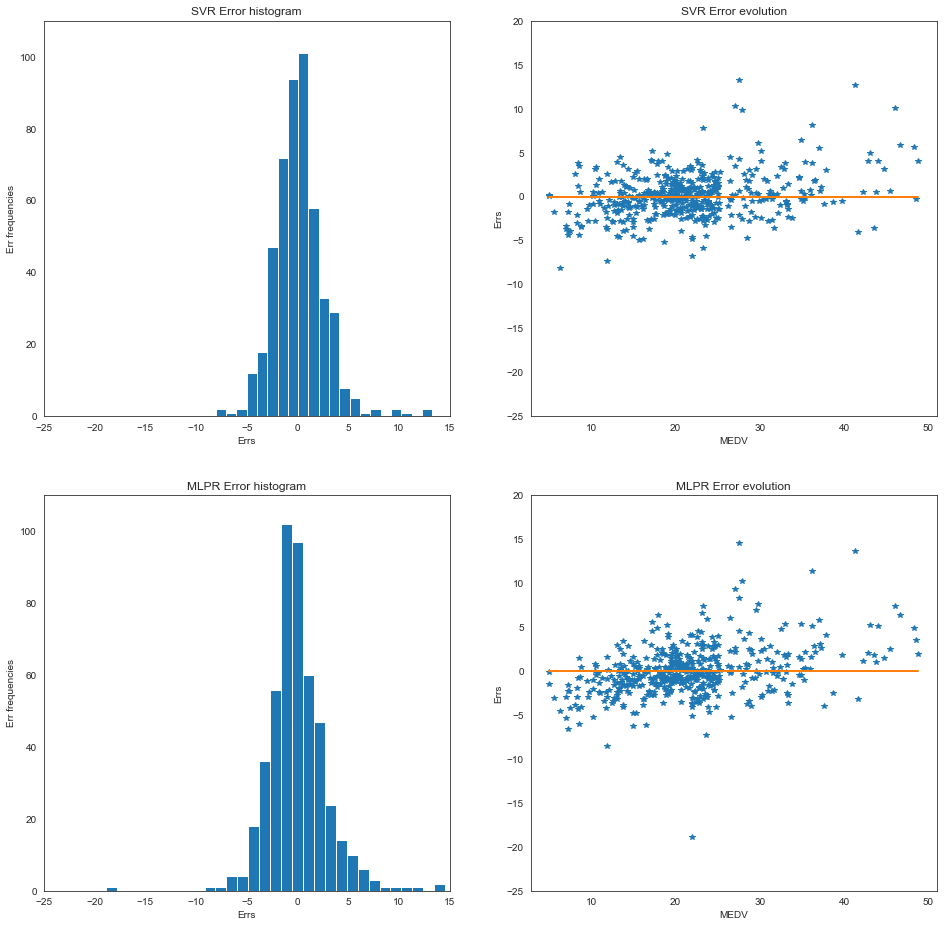

In [27]:
err_svr  = y - y_pred_svr
err_mlpr = y - y_pred_mlpr

plt.figure( figsize=(16,16))

plt.subplot(2,2,1)
plt.title("SVR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-25., 15.)
plt.ylim(0., 110.)
_ = plt.hist(err_svr, bins=21)

plt.subplot(2,2,2)
plt.title("SVR Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
plt.ylim(-25., 20.)
_ = plt.plot(y, err_svr, '*', y, 0.*y, '-')

plt.subplot(2,2,3)
plt.title("MLPR Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
plt.xlim(-25., 15.)
plt.ylim(0., 110.)
_ = plt.hist(err_mlpr, bins=31)

plt.subplot(2,2,4)
plt.title("MLPR Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
plt.ylim(-25., 20.)
_ = plt.plot(y, err_mlpr, '*', y, 0.*y, '-')

plt.show()